# Single Shot Multibox Detection (SSD)

In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '..')
import d2l
# from d2l.ssd_utils import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import json
import time
from tqdm import tqdm
from PIL import Image
def cls_predictor(input_channels, num_anchors, num_classes):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

In [2]:
def bbox_predictor(input_channels, num_anchors):
    return nn.Conv2d(in_channels=input_channels, out_channels=num_anchors * 4, kernel_size=3, padding=1)

In [3]:
def forward(x, block):
    return block(x)
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
(Y1.shape, Y2.shape)

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [4]:
def flatten_pred(pred):
    return pred.permute(0, 2, 3, 1).reshape(pred.size(0),-1)

def concat_preds(preds):
    return torch.cat(tuple([flatten_pred(p) for p in preds]), dim=1)

In [5]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [6]:
def down_sample_blk(input_channels, num_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels=input_channels, out_channels=num_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(num_features=num_channels))
        blk.append(nn.ReLU())
        input_channels=num_channels
    blk.append(nn.MaxPool2d(kernel_size=2, stride=2))
    blk = nn.Sequential(*blk)
    return blk

In [7]:
forward(torch.zeros((2, 3, 20, 20)), down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

In [8]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    blk = nn.Sequential(*blk)
    return blk

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

In [9]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    
    return blk

In [10]:
import itertools
import math
def create_anchors(feature_map_sizes, steps, sizes):
    """Compute default box sizes with scale and aspect transform."""
    scale = 256.
    steps = [s / scale for s in steps]
    sizes = [s / scale for s in sizes]
    
    aspect_ratios = ((2,),)


    num_layers = len(feature_map_sizes)

    boxes = []
    for i in range(num_layers):
        fmsize = feature_map_sizes[i]
        for h, w in itertools.product(range(fmsize), repeat=2):
            cx = (w + 0.5)*steps[i]
            cy = (h + 0.5)*steps[i]
            s = sizes[i]
            boxes.append((cx, cy, s, s))

            s = sizes[i+1]
            boxes.append((cx, cy, s, s))

            s = sizes[i]
            for ar in aspect_ratios[i]:
                
#                 boxes.append((cx - (s * math.sqrt(ar))/2, cy - (s / math.sqrt(ar))/2, cx + (s * math.sqrt(ar))/2, cy + (s / math.sqrt(ar))/2))
#                 boxes.append((cx - (s / math.sqrt(ar))/2, cy - (s * math.sqrt(ar))/2, cx + (s / math.sqrt(ar))/2, cy + (s * math.sqrt(ar))/2))

                boxes.append((cx, cy, (s * math.sqrt(ar)), (s / math.sqrt(ar))))
                boxes.append((cx, cy, (s / math.sqrt(ar)), (s * math.sqrt(ar))))

    return torch.Tensor(boxes) # [8632, 4]

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = create_anchors((Y.size(2),), (256/Y.size(2),), size)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [12]:
sizes = [[0.2*256, 0.272*256], [0.37*256, 0.447*256], [0.54*256, 0.619*256],
         [0.71*256, 0.79*256], [0.88*256, 0.961*256]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [13]:
class TinySSD(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(TinySSD, self).__init__()
        
        input_channels_cls = 128
        input_channels_bbox = 128
        self.num_classes = num_classes
        
        self.blk = []
        self.cls = []
        self.bbox = []
        
        self.blk_0 = get_blk(0)
        self.blk_1 = get_blk(1)
        self.blk_2 = get_blk(2)
        self.blk_3 = get_blk(3)
        self.blk_4 = get_blk(4)
        
        self.cls_0 = cls_predictor(64, num_anchors, num_classes)
        self.cls_1 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_2 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_3 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        self.cls_4 = cls_predictor(input_channels_cls, num_anchors, num_classes)
        
        self.bbox_0 = bbox_predictor(64, num_anchors)
        self.bbox_1 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_2 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_3 = bbox_predictor(input_channels_bbox, num_anchors)
        self.bbox_4 = bbox_predictor(input_channels_bbox, num_anchors)
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        
        X, anchors[0], cls_preds[0], bbox_preds[0] = blk_forward(X, self.blk_0, sizes[0], ratios[0],
                                                                    self.cls_0, self.bbox_0)
        
        X, anchors[1], cls_preds[1], bbox_preds[1] = blk_forward(X, self.blk_1, sizes[1], ratios[1],
                                                                    self.cls_1, self.bbox_1)
            
        X, anchors[2], cls_preds[2], bbox_preds[2] = blk_forward(X, self.blk_2, sizes[2], ratios[2],
                                                                    self.cls_2, self.bbox_2)    
        
        X, anchors[3], cls_preds[3], bbox_preds[3] = blk_forward(X, self.blk_3, sizes[3], ratios[3],
                                                                    self.cls_3, self.bbox_3)    
        
        X, anchors[4], cls_preds[4], bbox_preds[4] = blk_forward(X, self.blk_4, sizes[4], ratios[4],
                                                                    self.cls_4, self.bbox_4)    

        return (torch.cat(anchors, dim=0), concat_preds(cls_preds).reshape((-1, 5444, self.num_classes + 1)), 
                concat_preds(bbox_preds))

In [14]:
anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5

In [15]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        
net = TinySSD(3, num_classes=1)
net.apply(init_weights)

X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: torch.Size([5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


## Training

In [16]:
d2l.download_and_preprocess_data()

In [17]:
batch_size = 32
data_dir = '../data/pikachu/'
train_dataset = d2l.PIKACHU(data_dir, 'train')
val_dataset = d2l.PIKACHU(data_dir, 'val')

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size, shuffle=False,
                                         num_workers=4)

In [18]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '7' # You can set gpu no. if you have multiple gpus

In [19]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [20]:
net = TinySSD(3, num_classes=1)
net.apply(init_weights)
net = net.to(device)

learning_rate = 1e-3
weight_decay = 5e-4
optimizer = optim.SGD(net.parameters(), lr = learning_rate, weight_decay=weight_decay)

In [21]:
id_cat = dict()
id_cat[0] = 'pikachu'

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, device="cuda:0", eps=1e-10):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        self.eps = eps

    def forward(self, input, target):
        p = torch.sigmoid(input)
        pt = p * target.float() + (1.0 - p) * (1 - target).float()
        alpha_t = (1.0 - self.alpha) * target.float() + self.alpha * (1 - target).float()
        loss = - 1.0 * torch.pow((1 - pt), self.gamma) * torch.log(pt + self.eps)
        return loss.sum()
    
class SSDLoss(nn.Module):
    def __init__(self, loc_factor, jaccard_overlap, device = "cuda:0", **kwargs):
        super().__init__()
        self.fl = FocalLoss(**kwargs)
        self.loc_factor = loc_factor
        self.jaccard_overlap = jaccard_overlap
        

        
        self.device = device

    def one_hot_encoding(labels, num_classes):
        return torch.eye(num_classes)[labels.cpu()]

    def loc_transformation(x, anchors, overlap_indicies):
        # Doing location transformations according to SSD paper
        return torch.cat([(x[:, 0:1] - anchors[overlap_indicies, 0:1]) / anchors[overlap_indicies, 2:3],
                          (x[:, 1:2] - anchors[overlap_indicies, 1:2]) / anchors[overlap_indicies, 3:4],
                          torch.log((x[:, 2:3] / anchors[overlap_indicies, 2:3])),
                          torch.log((x[:, 3:4] / anchors[overlap_indicies, 3:4]))
                         ], dim=1)

    def forward(self, class_hat, bb_hat, class_true, bb_true, anchors):        
        loc_loss = 0.0
        class_loss = 0.0
    
        
        for i in range(len(class_true)):  # Batch level

            class_hat_i = class_hat[i, :, :]

            bb_true_i = bb_true[i].float()
            
            class_true_i = class_true[i]            
            
            class_target = torch.zeros(class_hat_i.shape[0]).long().to(self.device)
            
            overlap_list = d2l.find_overlap(bb_true_i.squeeze(0), anchors, self.jaccard_overlap)
            
            temp_loc_loss = 0.0
            for j in range(len(overlap_list)):  # BB level
                overlap = overlap_list[j]
                class_target[overlap] = class_true_i[0, j].long()

                input_ = bb_hat[i, overlap, :]
                target_ = SSDLoss.loc_transformation(bb_true_i[0, j, :].expand((len(overlap), 4)), anchors, overlap)

                temp_loc_loss += F.smooth_l1_loss(input=input_, target=target_, reduction="sum") / len(overlap)
            loc_loss += temp_loc_loss / class_true_i.shape[1]

            class_target = SSDLoss.one_hot_encoding(class_target, len(id_cat) + 1).float().to(self.device)
            class_loss += self.fl(class_hat_i, class_target) / class_true_i.shape[1]

        loc_loss = loc_loss / len(class_true)
        class_loss = class_loss / len(class_true)
        loss = class_loss + loc_loss * self.loc_factor

        return loss, loc_loss, class_loss

In [22]:
loss = SSDLoss(loc_factor=5.0, jaccard_overlap=0.5, device="cuda:0")

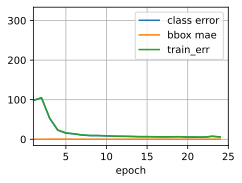

In [24]:
num_epochs = 25
init_epoch = 0

# Uncomment the following 2 lines if you wish to load a pre-trained/saved model
# checkpoint_path = './ssd_outputs/model-29_0.1411931432526687.pth'   # Mention the model name to load 
# init_epoch = d2l.load(net, checkpoint_path, optimizer)

animator = d2l.Animator(xlabel='epoch', xlim=[init_epoch+1, num_epochs],
                        legend=['class error', 'bbox mae', 'train_err'])
                        
for epoch in range(init_epoch, num_epochs):
        
    net.train()
    
    train_loss = 0.0
    loc_loss = 0.0
    class_loss = 0.0

    for i, (x, bb_true, class_true) in (enumerate(train_loader)):
        
        x = x.to(device)
        bb_true = bb_true.to(device)
        class_true = class_true.to(device)
        
        timer_start = time.time()
        
        anchors, cls_preds, bbox_preds = net(x)
        
        class_true = [*class_true.reshape((class_true.size(0), 1, 1))]
        bb_true = [*bb_true.reshape((bb_true.size(0), 1, 1, 4))]
        
        bbox_preds = bbox_preds.reshape((-1, 5444, 4))
        
        # Label the category and offset of each anchor box
        
        anchors = anchors.to(device)
                
        batch_loss, batch_loc_loss, batch_class_loss = loss(cls_preds, bbox_preds, class_true, bb_true, anchors)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        class_loss += batch_class_loss
        loc_loss += batch_loc_loss
        train_loss += batch_loss
        
#     Uncomment the following 2 line for saving the model every epoch
#     path_to_checkpoints_dir = './ssd_outputs/'
#     d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))
    
    train_loss = (train_loss/len(train_loader)).detach().cpu().numpy()
    loc_loss = (loc_loss/len(train_loader)).detach().cpu().numpy()
    class_loss = (class_loss/len(train_loader)).detach().cpu().numpy()
    
#     print(class_loss, loc_loss, train_loss, epoch+1)
    
    # Uncomment the following if you wish to see the results after every epoch to see the learning effect
    # Images will be saved to the 'results_every_epoch' directory
    
#     try:
#         d2l.infer(net, epoch, 0.9, device)
#     except Exception as e:
#         print(e, 'error' + str(epoch+1))
        
    
    animator.add(epoch, (class_loss, loc_loss, train_loss))  

In [25]:
path_to_checkpoints_dir = './ssd_outputs'
d2l.save(net, path_to_checkpoints_dir, epoch, optimizer, train_loss/len(train_loader))

'./ssd_outputs\\model-24_0.20638003842584018.pth'

## Prediction

In [26]:
img = np.array(Image.open('../img/pikachu.jpg').convert('RGB').resize((256, 256), Image.BILINEAR))
X = transforms.Compose([transforms.ToTensor()])(img).to(device)
X = X.to(device)

In [27]:
def predict(X, nms_threshold):
    background_threshold = 0.8
    net.eval()
    anchors, class_hat, bb_hat = net(X.unsqueeze(0))
    anchors = anchors.to(device)
    bb_hat = bb_hat.reshape((1, -1, 4))
    bb_hat = d2l.invert_transformation(bb_hat.squeeze(0), anchors)
    bb_hat = bb_hat * 256.0

    class_hat = class_hat.sigmoid().squeeze(0)

    bb_hat = bb_hat[class_hat[:,0] < background_threshold, :]


    bb_hat = bb_hat.detach().cpu().numpy()
    class_hat = class_hat[class_hat[:,0] < background_threshold, :]

    class_preds = class_hat[:, 1:]

    prob, class_id = torch.max(class_preds,1)

    prob = prob.detach().cpu().numpy()
    class_id = class_id.detach().cpu().numpy()



    output_bb = [d2l.PredBoundingBox(probability=1 - prob[i],
                                 class_id=class_id[i],
                                 classname=id_cat[class_id[i]],
                                 bounding_box=[bb_hat[i, 0], 
                                               bb_hat[i, 1], 
                                               bb_hat[i, 2], 
                                               bb_hat[i, 3]])
                                 for i in range(0, len(prob))]

    output_bb = sorted(output_bb, key = lambda x: x.probability, reverse=False)
    
    filtered_bb = d2l.non_max_suppression(output_bb, nms_threshold)
    
    return filtered_bb

filtered_bb = predict(X, 0.1)

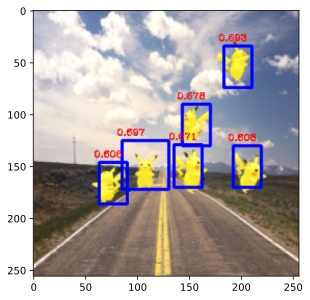

In [28]:
def display(img, output):

    img = d2l.draw_boxes(img, [bb.bounding_box for bb in filtered_bb])
    img = d2l.draw_text(img, [str(bb.probability)[:5] for bb in filtered_bb], [bb.bounding_box for bb in filtered_bb])
    d2l.plt.imshow(img)
    d2l.plt.show()

display(img, filtered_bb)

### Loss Function

In [29]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = np.arange(-2, 2, 0.1)
d2l.set_figsize()

In [30]:
def smooth_l1(x, scalar):
    a = []
    for i in x:
                
        if abs(i) < 1/((scalar)**2):
            a.append(((scalar*i)**2)/2)
        
        else:
            a.append(abs(i) - 0.5/((scalar)**2))
    
    return np.array(a)
    

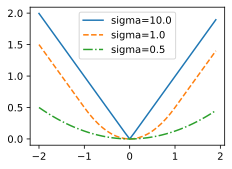

In [31]:
a1 = []
for l, s in zip(lines, sigmas):
    y = smooth_l1(x, scalar=s)
    d2l.plt.plot(x, y, l, label='sigma=%.1f' % s)
    
d2l.plt.legend();

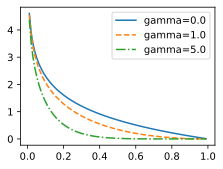

In [32]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, 0.01)

for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x, focal_loss(gamma, x), l,
                     label='gamma=%.1f' % gamma)
    
d2l.plt.legend();